* See if removing words can help us find anchor words

* See if removing words in a soft way (scale by cutoff) can help us find anchor words

In [23]:
import os
import sys
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import numpy as np
import time
import pickle
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

from scipy.stats import betabinom
from scipy.optimize import minimize
import magic
import scprep


script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 

datadir = "../../../gdrive/github_data/pyJSMF-RAW-data"
# %matplotlib widget


In [2]:
%%capture

## load data
dataname = "sla"
k = 6
rate=3

datafile=f"{datadir}/fit_sim_{dataname}_fastTopics_k{k}_rate{rate}.pkl"
with open(datafile, "rb") as f:
    fitted = pickle.load(f)
    
file = open(f'{datadir}/improve_C2.pkl', 'rb')
out = pickle.load(file)
file.close()

X = fitted['X'].toarray()
Ltrue = fitted['Ltrue']
Ftrue = fitted['Ftrue']


Pi_true = Ltrue @ Ftrue.T
Pi_eb = out["Pi"]
AB = out["AB"]
n, p = X.shape

# truth
Ctrue = Pi_true.T @ Pi_true / n
Cbar0 = Ctrue / Ctrue.sum(axis = 1)[:, None]

Pi = X / X.sum(axis = 1)[:, None]
C = Pi.T @ Pi / n
S0, _, _ = findS(Cbar0, k)

## naive Cbar
Cbar1 = C / C.sum(axis = 1)[:, None] 
S1, _, _ = findS(Cbar1, k)

Cbar0_pj = pca_proj(Cbar0)
Cbar1_pj = pca_proj(Cbar1)


In [3]:
X.shape

(3207, 8766)

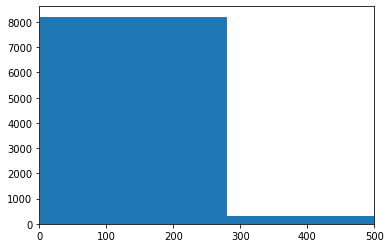

In [4]:
X_binary = (X > 0)
plt.hist(X_binary.sum(axis = 0))
plt.xlim(0, 500)
plt.show()

In [5]:
idx = np.where(X_binary.sum(axis = 0) < 10)
idx[0].shape

(2814,)

In [6]:
print(X_binary.sum(axis = 0)[S0])
print(X_binary.sum(axis = 0)[S1])

[198 769 346 313 396 559]
[4 5 4 5 5 5]


## Remove rare words

In [7]:
%%capture
idx = np.where(X_binary.sum(axis = 0) > 10)[0]
S0_rm, _, _ = findS(Cbar0[np.ix_(idx, idx)], k)
S1_rm, _, _ = findS(Cbar1[np.ix_(idx, idx)], k)

(5629,)
[3132 5101 3901 1426 2767 4785]
[ 109 4118  603  431 4078  481]
[198 935 438 313 396 559]
[11 24 16 19 12 11]
recoverS with true Cbar


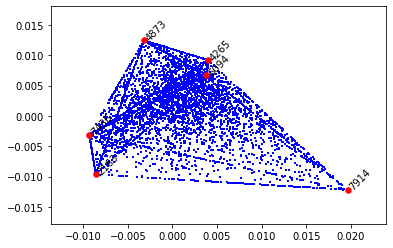

recoverS with Cbar1


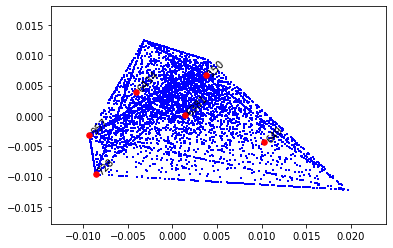

In [8]:
print(idx.shape)
print(S0_rm)
print(S1_rm)

print(X_binary.sum(axis = 0)[idx][S0_rm])
print(X_binary.sum(axis = 0)[idx][S1_rm])

which_dim = [0, 1]
print("recoverS with true Cbar")
vis_extremal_pca(Cbar0_pj, idx[S0_rm], which_dim = which_dim, annotate=True,fontsize=10)
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, idx[S1_rm], which_dim = which_dim, annotate=True,fontsize=10)

Try a higher threshold

In [9]:
%%capture
idx = np.where(X_binary.sum(axis = 0) > 30)[0]
S0_rm, _, _ = findS(Cbar0[np.ix_(idx, idx)], k)
S1_rm, _, _ = findS(Cbar1[np.ix_(idx, idx)], k)

(2973,)
[1681 2709 2047 1496  790 2520]
[2309 2389 1791 2480  644  124]
[198 935 438 396 313 559]
[31 40 35 38 45 37]
recoverS with true Cbar


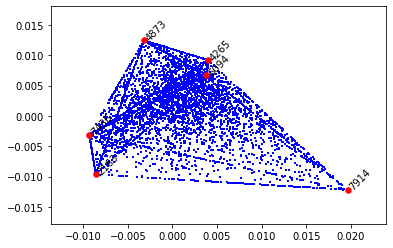

recoverS with Cbar1


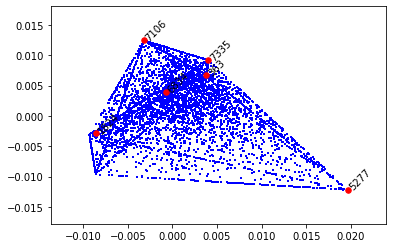

In [10]:
print(idx.shape)
print(S0_rm)
print(S1_rm)

print(X_binary.sum(axis = 0)[idx][S0_rm])
print(X_binary.sum(axis = 0)[idx][S1_rm])

which_dim = [0, 1]
print("recoverS with true Cbar")
vis_extremal_pca(Cbar0_pj, idx[S0_rm], which_dim = which_dim, annotate=True,fontsize=10)
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, idx[S1_rm], which_dim = which_dim, annotate=True,fontsize=10)

Try even higher threshold

In [11]:
%%capture
idx = np.where(X_binary.sum(axis = 0) > 50)[0]
S0_rm, _, _ = findS(Cbar0[np.ix_(idx, idx)], k)
S1_rm, _, _ = findS(Cbar1[np.ix_(idx, idx)], k)

(2202,)
[1253 2009 1538 1110  594 1876]
[2069 1922 1577  723 1287 2158]
[198 935 438 396 313 559]
[55 74 55 55 65 64]
recoverS with true Cbar


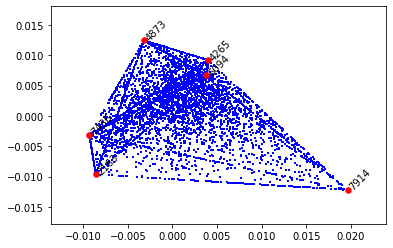

recoverS with Cbar1


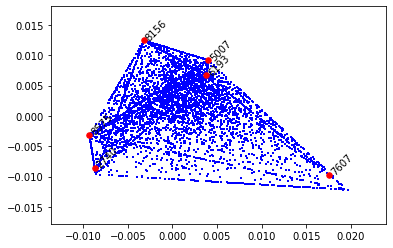

In [12]:
print(idx.shape)
print(S0_rm)
print(S1_rm)

print(X_binary.sum(axis = 0)[idx][S0_rm])
print(X_binary.sum(axis = 0)[idx][S1_rm])

which_dim = [0, 1]
print("recoverS with true Cbar")
vis_extremal_pca(Cbar0_pj, idx[S0_rm], which_dim = which_dim, annotate=True,fontsize=10)
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, idx[S1_rm], which_dim = which_dim, annotate=True,fontsize=10)

* It's tricky to decide the threshold
* Even throwing away most "useless" words, the algorithm still favors rarer words; it's just that they are not too far away from true anchor words (the variance is smaller)

## Remove rare words, softly

In [13]:
%%capture

d = C.sum(axis = 1)
cutoff = np.quantile(d, [0.6])[0] 
d[d < cutoff] = cutoff
Cbar_soft = C / d[:, None]
S_soft, _, _ = findS(Cbar_soft, k)

[ 4  8  8 11 15 12]
recoverS with Cbar1


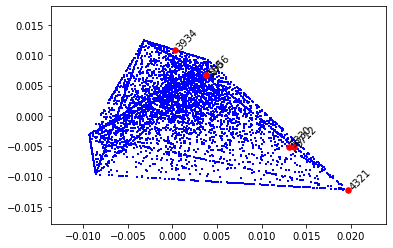

In [14]:
print(X_binary.sum(axis = 0)[S_soft])

which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_soft, which_dim = which_dim, annotate=True,fontsize=10)

try higher cutoff

In [15]:
%%capture

d = C.sum(axis = 1)
cutoff = np.quantile(d, [0.75])[0] 
d[d < cutoff] = cutoff
Cbar_soft = C / d[:, None]
S_soft, _, _ = findS(Cbar_soft, k)

[31 55 74  8 48 55]
recoverS with Cbar1


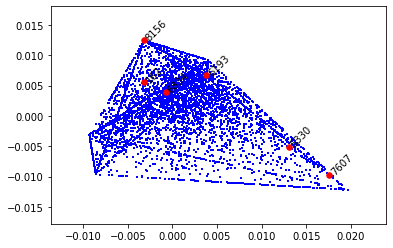

In [16]:
print(X_binary.sum(axis = 0)[S_soft])

which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_soft, which_dim = which_dim, annotate=True,fontsize=10)

In [17]:
%%capture

d = C.sum(axis = 1)
cutoff = np.quantile(d, [0.95])[0] 
d[d < cutoff] = cutoff
Cbar_soft = C / d[:, None]
S_soft, _, _ = findS(Cbar_soft, k)

[393 935 559 346 396 304]
recoverS with Cbar1


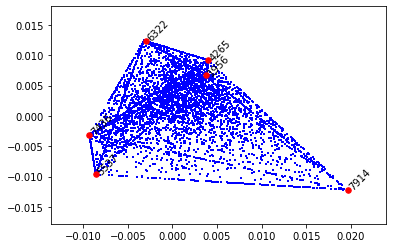

In [18]:
print(X_binary.sum(axis = 0)[S_soft])

which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_soft, which_dim = which_dim, annotate=True,fontsize=10)

## Try Magic

In [36]:
X_normalized = scprep.normalize.library_size_normalize(X)
X_normalized = scprep.transform.sqrt(X_normalized)


magic_op = magic.MAGIC()
X_magic = magic_op.fit_transform(X_normalized, genes="all_genes")


magic_op2 = magic.MAGIC()
magic_op2.fit(X_normalized)
X_magic2 = magic_op2.transform(X)

Calculating MAGIC...
  Running MAGIC on 3207 cells and 8766 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.09 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.98 seconds.
    Calculating affinities...
    Calculated affinities in 0.94 seconds.
  Calculated graph and diffusion operator in 3.02 seconds.
  Running MAGIC with `solver='exact'` on 8766-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 1.79 seconds.
Calculated MAGIC in 4.83 seconds.
Running MAGIC on 3207 cells and 8766 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.11 seconds.
  Calculating KNN search...
  Calculated KNN search in 1.01 seconds.
  Calculating affinities...
  Calculated affinities in 0.98 seconds.
Calculated graph and diffusion operator in 3.11 seconds.
Runni

/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 1.91 seconds.


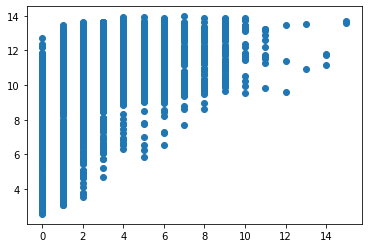

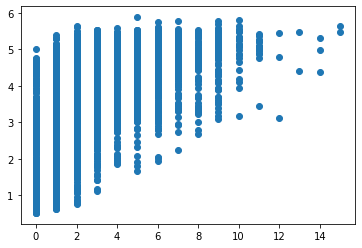

In [37]:
idx = np.argmax(X.sum(axis = 0))
plt.scatter(X[:,idx], X_magic[:, idx])
plt.show()

plt.scatter(X[:,idx], X_magic2[:, idx])
plt.show()

In [42]:
print(X_magic.sum())
print(X_normalized.sum())
print(X_magic2.sum())
print(X.sum())

4727985.073194226
4431896.9868522845
959024.7527659484
818802.0


[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.2064 seconds

[5971 1326 7218 6874 3591  959]
[4 1 1 3 1 3]
recoverS with Cbar1


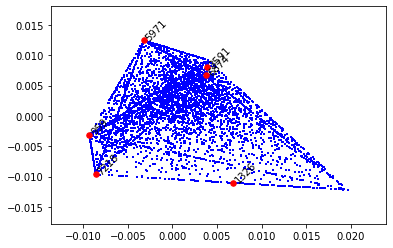

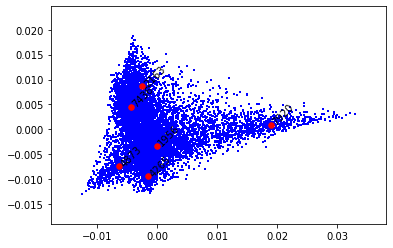

In [53]:
Pi_m = X_magic2 / X_magic2.sum(axis = 1)[:, None]
C_m = Pi_m.T @ Pi_m / n

## naive Cbar
Cbar_m = C_m / C_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)

print(S_m)
print(X_binary.sum(axis = 0)[S_m])

which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)

vis_extremal_pca(Cbar_proj(Cbar_m), S0, which_dim = which_dim, annotate=True,fontsize=10)


[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.4777 seconds

[5971 1326 7218  455 3591  959]
[4 1 1 3 1 3]
recoverS with Cbar1


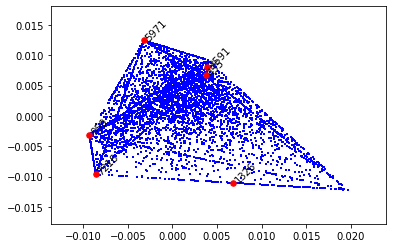

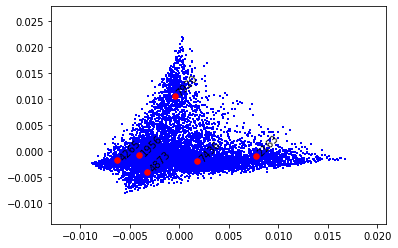

In [52]:
Pi_m = X_magic / X_magic.sum(axis = 1)[:, None]
C_m = Pi_m.T @ Pi_m / n

## naive Cbar
Cbar_m = C_m / C_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)

print(S_m)
print(X_binary.sum(axis = 0)[S_m])

which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)

vis_extremal_pca(Cbar_proj(Cbar_m), S0, which_dim = which_dim, annotate=True,fontsize=10)


It has better performance than doing nothing. Still I believe rare words have larger variance after MAGIC step that affects our model. Also there's tuning parameter $t$ that we can play with

## Apply MAGIC to $X^T$ ? 
Does not sound like a good idea, still try it

In [54]:
Y_normalized = scprep.normalize.library_size_normalize(X.T)
Y_normalized = scprep.transform.sqrt(Y_normalized)


magic_op = magic.MAGIC()
Y_magic = magic_op.fit_transform(Y_normalized, genes="all_genes")


magic_op2 = magic.MAGIC()
magic_op2.fit(Y_normalized)
Y_magic2 = magic_op2.transform(X.T)

Calculating MAGIC...
  Running MAGIC on 8766 cells and 3207 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.16 seconds.
    Calculating KNN search...
    Calculated KNN search in 8.84 seconds.
    Calculating affinities...
    Calculated affinities in 9.60 seconds.
  Calculated graph and diffusion operator in 19.62 seconds.
  Calculating imputation...
  Calculated imputation in 2.13 seconds.
Calculated MAGIC in 21.78 seconds.
Running MAGIC on 8766 cells and 3207 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.09 seconds.
  Calculating KNN search...
  Calculated KNN search in 8.08 seconds.
  Calculating affinities...
  Calculated affinities in 8.57 seconds.
Calculated graph and diffusion operator in 17.76 seconds.
Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 2.49 seconds.


[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.2977 seconds

[8694 7914 4892 3416 7976 7780]
[231 935 205 269 212 134]
recoverS with Cbar1


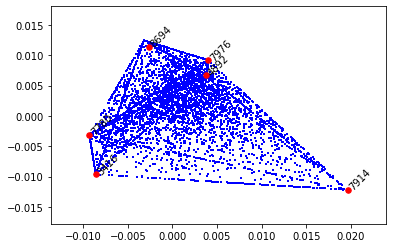

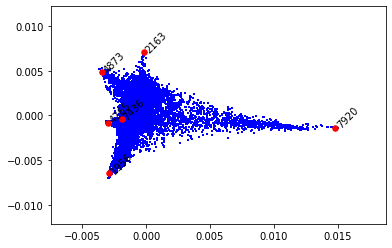

In [55]:
Pi_m = Y_magic2.T / Y_magic2.T.sum(axis = 1)[:, None]
C_m = Pi_m.T @ Pi_m / n

## naive Cbar
Cbar_m = C_m / C_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)

print(S_m)
print(X_binary.sum(axis = 0)[S_m])

which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)

vis_extremal_pca(Cbar_proj(Cbar_m), S0, which_dim = which_dim, annotate=True,fontsize=10)


[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.2903 seconds

[ 758 7075 7895  907 2294 2951]
[  4 113   5   8   4 242]
recoverS with Cbar1


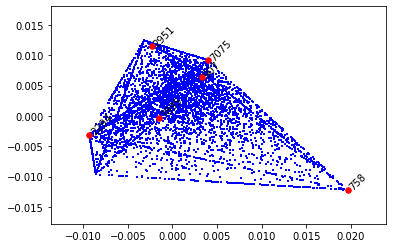

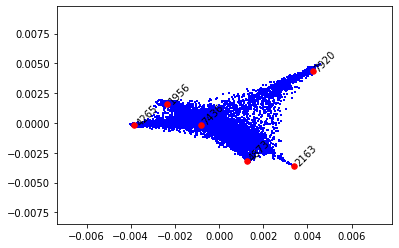

In [56]:
Pi_m = Y_magic.T / Y_magic.T.sum(axis = 1)[:, None]
C_m = Pi_m.T @ Pi_m / n

## naive Cbar
Cbar_m = C_m / C_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)

print(S_m)
print(X_binary.sum(axis = 0)[S_m])

which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)

vis_extremal_pca(Cbar_proj(Cbar_m), S0, which_dim = which_dim, annotate=True,fontsize=10)


SURPRISE!!

The first application of magic is the right one (impute on original matrix). It's great that it gives the right result. 

## First denoise using MAGIC; then shrink using MAGIC on $X^T_{\text{denoised}}$

In [57]:
X_normalized = scprep.normalize.library_size_normalize(X)
X_normalized = scprep.transform.sqrt(X_normalized)
magic_op = magic.MAGIC()
magic_op.fit(X_normalized)
X_magic = magic_op.transform(X)

Running MAGIC on 3207 cells and 8766 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.09 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.94 seconds.
  Calculating affinities...
  Calculated affinities in 0.92 seconds.
Calculated graph and diffusion operator in 2.96 seconds.
Running MAGIC with `solver='exact'` on 8766-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 1.71 seconds.


In [58]:
Y_normalized = scprep.normalize.library_size_normalize(X_magic.T)
Y_normalized = scprep.transform.sqrt(Y_normalized)

magic_op = magic.MAGIC()
magic_op.fit(Y_normalized)
Y_magic = magic_op.transform(X_magic.T)

Running MAGIC on 8766 cells and 3207 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.06 seconds.
  Calculating KNN search...
  Calculated KNN search in 5.67 seconds.
  Calculating affinities...
  Calculated affinities in 4.76 seconds.
Calculated graph and diffusion operator in 11.50 seconds.
Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 2.05 seconds.


[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.2350 seconds

[5971 1326 7218   23 6292  959]
[4 1 1 4 2 3]
recoverS with Cbar1


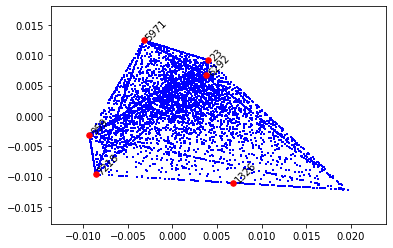

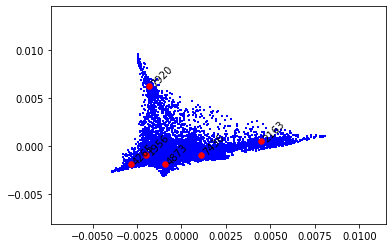

In [59]:
Pi_m = Y_magic.T / Y_magic.T.sum(axis = 1)[:, None]
C_m = Pi_m.T @ Pi_m / n

## naive Cbar
Cbar_m = C_m / C_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)

print(S_m)
print(X_binary.sum(axis = 0)[S_m])

which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)

vis_extremal_pca(Cbar_proj(Cbar_m), S0, which_dim = which_dim, annotate=True,fontsize=10)


## Try harder data

In [61]:
%%capture

## load data
dataname = "sla"
k = 6
rate=1

datafile=f"{datadir}/fit_sim_{dataname}_fastTopics_k{k}_rate{rate}.pkl"
with open(datafile, "rb") as f:
    fitted = pickle.load(f)
    
file = open(f'{datadir}/improve_C2.pkl', 'rb')
out = pickle.load(file)
file.close()

X = fitted['X'].toarray()
Ltrue = fitted['Ltrue']
Ftrue = fitted['Ftrue']


Pi_true = Ltrue @ Ftrue.T
Pi_eb = out["Pi"]
AB = out["AB"]
n, p = X.shape

# truth
Ctrue = Pi_true.T @ Pi_true / n
Cbar0 = Ctrue / Ctrue.sum(axis = 1)[:, None]

Pi = X / X.sum(axis = 1)[:, None]
C = Pi.T @ Pi / n
S0, _, _ = findS(Cbar0, k)

## naive Cbar
Cbar1 = C / C.sum(axis = 1)[:, None] 
S1, _, _ = findS(Cbar1, k)

Cbar0_pj = pca_proj(Cbar0)
Cbar1_pj = pca_proj(Cbar1)

In [63]:
Y_normalized = scprep.normalize.library_size_normalize(X.T)
Y_normalized = scprep.transform.sqrt(Y_normalized)

magic_op = magic.MAGIC()
magic_op.fit(Y_normalized)
Y_magic = magic_op.transform(X.T)

Running MAGIC on 8386 cells and 3207 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.07 seconds.
  Calculating KNN search...
  Calculated KNN search in 8.45 seconds.
  Calculating affinities...


/home/zihao/.local/lib/python3.7/site-packages/graphtools/graphs.py:293: RuntimeWarning: Detected zero distance between 125 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  RuntimeWarning,


  Calculated affinities in 8.36 seconds.
Calculated graph and diffusion operator in 17.89 seconds.
Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 1.94 seconds.


[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.2330 seconds

[6785 7574 4251 2541 2699 5743]
[ 8 21  6  7  3 25]
recoverS with Cbar1


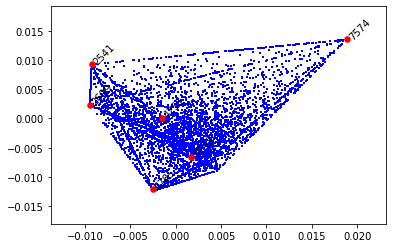

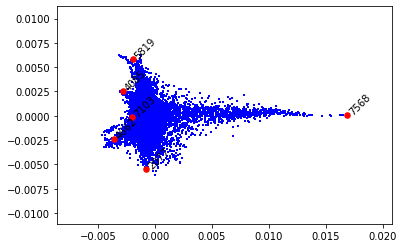

In [64]:
Pi_m = Y_magic.T / Y_magic.T.sum(axis = 1)[:, None]
C_m = Pi_m.T @ Pi_m / n

## naive Cbar
Cbar_m = C_m / C_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)

print(S_m)
print(X_binary.sum(axis = 0)[S_m])

which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)

vis_extremal_pca(Cbar_proj(Cbar_m), S0, which_dim = which_dim, annotate=True,fontsize=10)


So we can view MAGIC on genes as a form of shrinkage. Seems we can control the shrinkage effect by tuning hyperparameters. 

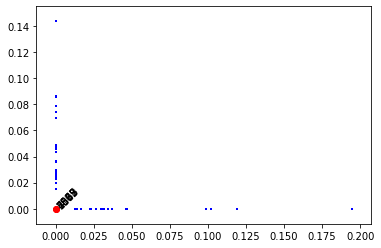

In [67]:

vis_extremal_pca(magic_op.diff_op.toarray(), S0, which_dim = which_dim, annotate=True,fontsize=10)
